In [1]:
from models import q_net
from models import utils as mutils

from flax.training import train_state, checkpoints
from typing import Any

import optax
import os
import jax
import jax.numpy as jnp

import math

import matplotlib.pyplot as plt

# tf.config.experimental.set_visible_devices([], "GPU") # Отключение GPU для TensorFlow
  # tf.config.experimental.set_visible_devices([], "TPU") # Отключение TPU для TensorFlow

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

2025-05-18 14:20:09.282754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747578009.304616   33628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747578009.311659   33628 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Q = q_net.RegressionInceptionNetV1()
ckpt_dir = os.path.abspath("./Q_checkpoint")
state_dict = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=None)

class TrainState(train_state.TrainState):
	batch_stats: Any
Q_state = TrainState.create(apply_fn=Q.apply,
							params=state_dict["params"],
							batch_stats=state_dict["batch_stats"],
							tx=optax.identity())

/home/pvshapka/AM/.venv/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [3]:
import sys
from absl import flags
from ml_collections.config_flags import config_flags

# Очистить флаги, если запускали ячейку ранее
flags.FLAGS.unparse_flags()

# Добавить свои параметры в sys.argv
sys.argv = [
    'notebook',  # фиктивное имя скрипта
    '--config=configs/am/cifar/generation.py',
    '--workdir=./checkpoint/',
    '--mode=train',
    '--eval_folder=eval'
]

# Теперь можно определить флаги
config_flags.DEFINE_config_file("config", None, "Training configuration.", lock_config=True)
flags.DEFINE_string("workdir", None, "Work directory.")
flags.DEFINE_enum("mode", None, ["train", "eval", "fid_stats"], "Running mode: train, eval or fid_stats")
flags.DEFINE_string("eval_folder", "eval", "The folder name for storing evaluation results")

# Инициализировать флаги
FLAGS = flags.FLAGS
FLAGS(sys.argv)  # или просто flags.FLAGS(sys.argv)

config = FLAGS.config
workdir = os.path.abspath(FLAGS.workdir)

In [4]:
config.train.batch_size = 32
config.train.batch_size

32

In [5]:
from dynamics import dynamics
from dynamics import utils as dutils
import datasets
from models import anet, ddpm

key = jax.random.PRNGKey(config.seed) # фиксирование ключа генерации случайных чисел
model, _, initial_params = mutils.init_model(key, config) # anet

q_t = dutils.get_dynamics(config.data.dynamics) # generation: (1 - t) * noise + t * data
time_sampler, init_sampler_state = dutils.get_time_sampler(config)
optimizer = optax.identity()
opt_state = optimizer.init(initial_params)

state = mutils.State(step=1,
					opt_state=opt_state,
					model_params=initial_params,
					ema_rate=config.model.ema_rate,
					params_ema=initial_params,
					sampler_state=init_sampler_state,
					key=key, wandbid=None)

checkpoint_dir = os.path.join(workdir, "checkpoints")
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

train_ds, _, _ = datasets.get_dataset(config, 
									additional_dim=config.train.n_jitted_steps, # количество итераций в рамках одного шага в цикле for
									uniform_dequantization=config.data.uniform_dequantization)
train_iter = iter(train_ds)
scaler = datasets.get_image_scaler(config)
inverse_scaler = datasets.get_image_inverse_scaler(config)
sampler_state = state.sampler_state

I0000 00:00:1747578030.663046   33628 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 71748 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:8b:00.0, compute capability: 8.0


In [6]:
batch = jax.tree_map(lambda x: scaler(x._numpy()), next(train_iter))
data = batch['image'][0, 0, ...]
params = state.model_params

/tmp/ipykernel_33628/2348166228.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  batch = jax.tree_map(lambda x: scaler(x._numpy()), next(train_iter))


In [7]:
data.shape

(32, 32, 32, 3)

In [8]:
keys = jax.random.split(key, num=5)
s = mutils.get_model_fn(model, params, train=True) # Функция модели f(t, x)
dsdtdx_fn = jax.grad(lambda t,x,_key: s(t,x,_key).sum(), argnums=[0,1])

In [9]:
bs = config.train.batch_size

t_0, t_1 = config.data.t_0*jnp.ones((bs,1,1,1)), config.data.t_1*jnp.ones((bs,1,1,1))
t, next_sampler_state = time_sampler.sample_t(bs, sampler_state) # sample_uniformly function
t = jnp.expand_dims(t, (1,2,3)) # [1, 2, 3] -> [ [[[1]]], [[[2]]], [[[3]]] ]
# sample data
x_0, x_1, x_t = q_t(keys[0], data, t, t_0, t_1) # (1 - t) * noise + t * data

# time loss
dsdt, dsdx = dsdtdx_fn(t, x_t, keys[3])

In [14]:
t.shape

(32, 1, 1, 1)

In [10]:
order_idx = jnp.argsort(math.sqrt(2)*jnp.arange(x_t.shape[0]) % 1, axis=0)
order_idx

Array([ 0, 29, 17,  5, 22, 10, 27, 15,  3, 20,  8, 25, 13,  1, 30, 18,  6,
       23, 11, 28, 16,  4, 21,  9, 26, 14,  2, 31, 19,  7, 24, 12],      dtype=int32)

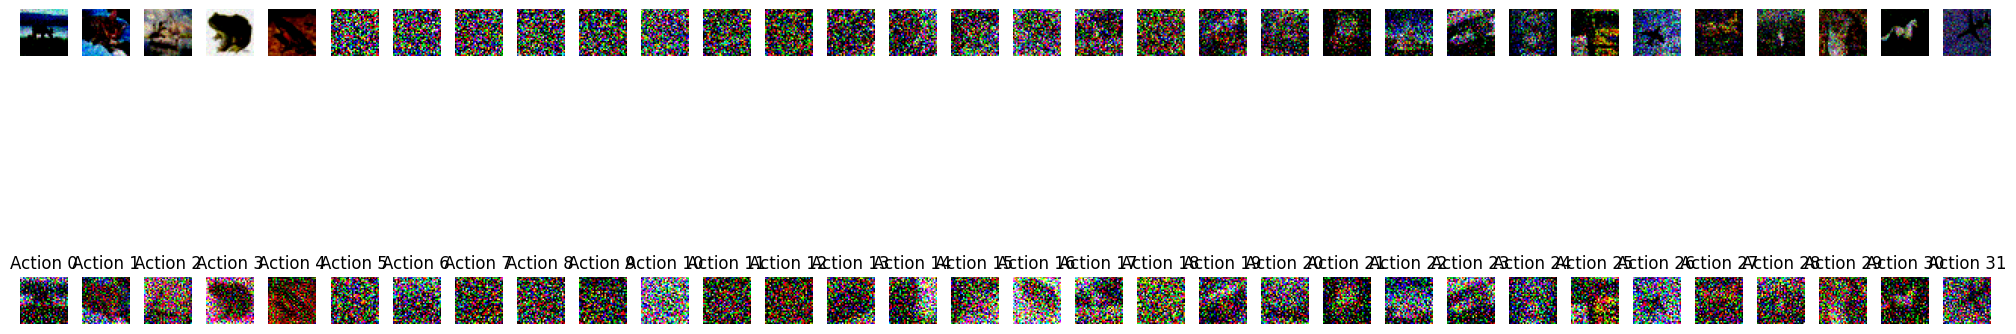

In [11]:
CIFAR10_STD = 1
CIFAR10_MEANS = 0
def plot_trajectory(s, a, s_next=None, a_next=None, num_steps=15, with_final_state=True):
    lines = 5 if a_next is not None else 3
    plt.figure(figsize=(20, 3 * lines))

    for i in range(num_steps):
        # State
        plt.subplot(lines, num_steps, i+1)
        plt.imshow((s[i] * CIFAR10_STD + CIFAR10_MEANS))  # Денормализация
        # plt.title(f"State {i}\nReward: {val_rewards[i][0]:.3f}")
        plt.axis('off')

        # Action (визуализируем как разницу)
        plt.subplot(lines, num_steps, num_steps+i+1)
        plt.imshow((a[i] * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Action {i}")
        plt.axis('off')

        # if with_final_state or actions_next is not None:
        #     # Next State
        #     s_next = s[i] + a[i] if s_next is None else s_next
        #     plt.subplot(lines, num_steps, 2*num_steps+i+1)
        #     plt.imshow((s_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        #     plt.title(f"Next State {i}")
        #     plt.axis('off')

        # if actions_next is None:
        #     continue

        # a_next = a_next if a_next is not None else None
        # plt.subplot(lines, num_steps, 3*num_steps+i+1)
        # plt.imshow((a_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        # plt.title(f"Next Action {i}")
        # plt.axis('off')

        # if with_final_state:
        #     s_next_next = s_next + a_next
        #     plt.subplot(lines, num_steps, 4*num_steps+i+1)
        #     plt.imshow((s_next_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        #     plt.title(f"Final State {i}")
        #     plt.axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем первую траекторию в батче
plot_trajectory(x_t[order_idx], dsdx[order_idx], s_next=None, a_next=None, num_steps=x_t.shape[0], with_final_state=True)

[]

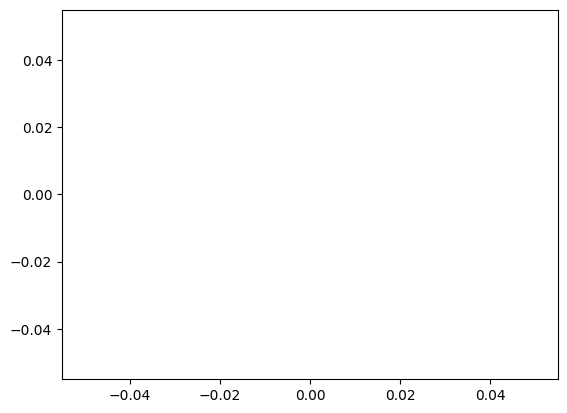

In [12]:
dsdx.shape
plt.plot()